In [79]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [80]:
# Relative path from the 'notebooks' folder to the 'data' folder
file_path = '../../data/AirData.xlsx'

# Load the data into a pandas DataFrame
df = pd.read_excel(file_path)

# Preview the data
df.head()

,BTY,Unnamed: 1,BTY UV,Unnamed: 3,CB UV,Unnamed: 5,CB,Unnamed: 7,DHB UV,Unnamed: 9,...,MPD UV,Unnamed: 13,MPD,Unnamed: 15,EG,Unnamed: 17,EG UV,Unnamed: 19,THB,Unnamed: 21
0,Time (min.),Thickness,Time (min.),Thickness,Time (min.),Thickness,Time (min.),Thickness,Time (min.),Thickness,...,Time (min.),Thickness,Time (min.),Thickness,Time (min.),Thickness,Time (min.),Thickness,Time (min.),Thickness
1,0.08415,486.033081,0.091225,617.004883,0.0943,192.170654,0.079658,190.71965,0.079842,417.420074,...,0.092392,100.433502,0.081008,84.964592,0.080742,404.262939,0.091633,222.753494,0.0816,311.070404
2,0.276942,486.546295,0.279158,617.812134,0.295042,191.881134,0.243208,191.497375,0.240767,418.197174,...,0.285267,102.808456,0.246667,86.743263,0.245242,405.245544,0.275767,223.398041,0.245258,311.5495
3,0.4613,485.959229,0.466675,618.532898,0.483958,192.079803,0.404542,192.441498,0.399358,418.237488,...,0.478017,104.296356,0.410117,88.357735,0.412625,405.755798,0.466875,223.39772,0.407425,310.427246
4,0.646225,486.098297,0.654325,620.99707,0.673325,192.113174,0.565017,192.175873,0.55805,418.129883,...,0.667025,105.146553,0.573483,88.945076,0.58075,406.300262,0.652242,223.559372,0.569592,310.407043


In [81]:
# Function to normalize the y-values so the first data point is 1
def normalize_data(y_values):
    """Normalize the data so that the first value is 1."""
    return y_values / y_values.iloc[0]

# Function to clean and convert columns to numeric
def clean_numeric_data(df, time_col, thickness_col):
    """Convert the time and thickness columns to numeric and drop rows with missing values."""
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    df[thickness_col] = pd.to_numeric(df[thickness_col], errors='coerce')
    return df[[time_col, thickness_col]].dropna()


In [82]:
def plot_uv_non_uv_pair(df, group_pair, group_names, x_limits=(0, 120), y_limits=(0, 1.2), save_plot=False, output_filename=None):
    """Generate a smoothed and normalized line plot for a UV and non-UV group pair, or just a single dataset, with an option to save the plot."""
    
    # If group_pair contains only one dataset, handle as a single dataset case
    if isinstance(group_pair, str):
        time_col, thickness_col = group_names[group_pair]
        
        # Clean and prepare the data
        df_group = clean_numeric_data(df.copy(), time_col, thickness_col)
        
        # Check if data is available
        if df_group.empty:
            print(f"No data available for {group_pair}. Skipping plot.")
            return
        
        # Normalize the thickness data
        df_group[thickness_col] = normalize_data(df_group[thickness_col])
        
        # Smooth the y-values using a Gaussian filter
        smoothed_group = gaussian_filter1d(df_group[thickness_col], sigma=1)
        
        # Create the plot for the single dataset
        plt.figure(figsize=(10, 6))
        plt.plot(df_group[time_col], smoothed_group, label=f'{group_pair}', color='blue')
        
        # Add annotation for the final percentage value
        final_value = smoothed_group[-1] * 100
        plt.annotate(f'{final_value:.2f}%', 
                     xy=(df_group[time_col].iloc[-1], smoothed_group[-1]),
                     xytext=(df_group[time_col].iloc[-1] + 5, smoothed_group[-1]),
                     textcoords='data',
                     arrowprops=dict(arrowstyle='->', lw=0.5),
                     fontsize=10, color='blue')
        
        # Add titles, labels, and limits
        plt.title(f'Normalized Time vs Thickness for {group_pair}')
        plt.xlabel('Time (min)')
        plt.ylabel('Normalized Thickness')
        plt.xlim(x_limits)
        plt.ylim(y_limits)
        
        # Add grid and legend
        plt.legend()
        plt.grid(True)
    
    else:
        # Handle the case where there is a UV and non-UV pair
        non_uv_group, uv_group = group_pair
        time_non_uv, thickness_non_uv = group_names[non_uv_group]
        time_uv, thickness_uv = group_names[uv_group]
        
        # Clean and prepare the data
        df_non_uv = clean_numeric_data(df.copy(), time_non_uv, thickness_non_uv)
        df_uv = clean_numeric_data(df.copy(), time_uv, thickness_uv)
        
        # Check if data is available
        if df_non_uv.empty or df_uv.empty:
            print(f"No data available for {non_uv_group} and/or {uv_group}. Skipping plot.")
            return
        
        # Normalize the thickness data
        df_non_uv[thickness_non_uv] = normalize_data(df_non_uv[thickness_non_uv])
        df_uv[thickness_uv] = normalize_data(df_uv[thickness_uv])
        
        # Smooth the y-values using a Gaussian filter
        smoothed_non_uv = gaussian_filter1d(df_non_uv[thickness_non_uv], sigma=1)
        smoothed_uv = gaussian_filter1d(df_uv[thickness_uv], sigma=1)
        
        # Create a new figure for each pair
        plt.figure(figsize=(10, 6))
        
        # Line plot for non-UV group (smoothed)
        plt.plot(df_non_uv[time_non_uv], smoothed_non_uv, label=f'{non_uv_group}', color='blue')
        
        # Line plot for UV group (smoothed)
        plt.plot(df_uv[time_uv], smoothed_uv, label=f'{uv_group}', color='red')
        
        # Add annotation for the final percentage value for non-UV line
        final_value_non_uv = smoothed_non_uv[-1] * 100
        plt.annotate(f'{final_value_non_uv:.2f}%', 
                     xy=(df_non_uv[time_non_uv].iloc[-1], smoothed_non_uv[-1]),
                     xytext=(df_non_uv[time_non_uv].iloc[-1] + 5, smoothed_non_uv[-1]),
                     textcoords='data',
                     arrowprops=dict(arrowstyle='->', lw=0.5),
                     fontsize=10, color='blue')

        # Add annotation for the final percentage value for UV line
        final_value_uv = smoothed_uv[-1] * 100
        plt.annotate(f'{final_value_uv:.2f}%', 
                     xy=(df_uv[time_uv].iloc[-1], smoothed_uv[-1]),
                     xytext=(df_uv[time_uv].iloc[-1] + 5, smoothed_uv[-1]),
                     textcoords='data',
                     arrowprops=dict(arrowstyle='->', lw=0.5),
                     fontsize=10, color='red')
        
        # Add titles, labels, and limits
        plt.title(f'Normalized Time vs Thickness for {non_uv_group} and {uv_group}')
        plt.xlabel('Time (min)')
        plt.ylabel('Normalized Thickness')
        plt.xlim(x_limits)
        plt.ylim(y_limits)
        
        # Add grid and legend
        plt.legend()
        plt.grid(True)
    
    # Save the figure if required
    if save_plot:
        if output_filename is None:
            # Generate a default filename if none is provided
            if isinstance(group_pair, str):
                output_filename = f'plot_{group_pair}.png'
            else:
                non_uv_group, uv_group = group_pair
                output_filename = f'plot_{non_uv_group}_and_{uv_group}.png'
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {os.path.abspath(output_filename)}")
    
    # Show the plot
    plt.show()


In [83]:
import os

def plot_all_and_save(df, group_pairs, group_names, output_dir='figures/'):
    """Generate and save all plots for each dataset in group_pairs."""
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    for group_pair in group_pairs:
        if isinstance(group_pair, tuple):
            # If group_pair is a tuple, it's a UV and non-UV pair
            non_uv_group, uv_group = group_pair
            filename = f'plot_{non_uv_group}_and_{uv_group}.png'
            output_filename = os.path.join(output_dir, filename)
            plot_uv_non_uv_pair(df, group_pair, group_names, save_plot=True, output_filename=output_filename)
        else:
            # If group_pair is not a tuple, it's a single dataset
            filename = f'plot_{group_pair}.png'
            output_filename = os.path.join(output_dir, filename)
            plot_uv_non_uv_pair(df, group_pair, group_names, save_plot=True, output_filename=output_filename)


In [84]:
# Group names for each pair of Time and Thickness columns
groups = {
    'BTY': ['BTY', 'Unnamed: 1'],
    'BTY UV': ['BTY UV', 'Unnamed: 3'],
    'CB UV': ['CB UV', 'Unnamed: 5'],
    'CB': ['CB', 'Unnamed: 7'],
    'DHB UV': ['DHB UV', 'Unnamed: 9'],
    'DHB': ['DHB', 'Unnamed: 11'],
    'MPD UV': ['MPD UV', 'Unnamed: 13'],
    'MPD': ['MPD', 'Unnamed: 15'],
    'EG': ['EG', 'Unnamed: 17'],
    'EG UV': ['EG UV', 'Unnamed: 19'],
    'THB': ['THB', 'Unnamed: 21']
}

# Pairs of UV and non-UV columns for combined plotting
group_pairs = [
    ('BTY', 'BTY UV'),
    ('CB', 'CB UV'),
    ('DHB', 'DHB UV'),
    ('MPD', 'MPD UV'),
    ('EG', 'EG UV'),
    ('THB')
]

Plot saved as D:\Users\themi\DataspellProjects\MetalconeStability\src\notebooks\figures\plot_BTY_and_BTY UV.png


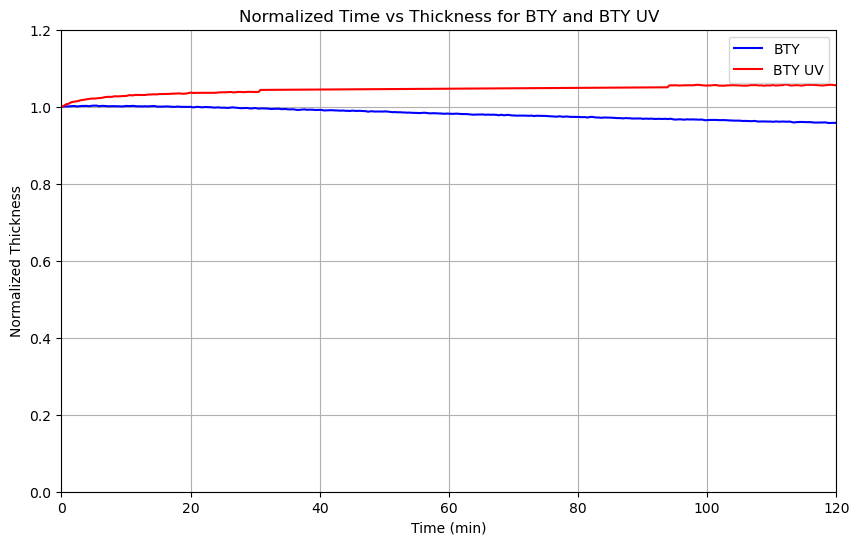

Plot saved as D:\Users\themi\DataspellProjects\MetalconeStability\src\notebooks\figures\plot_CB_and_CB UV.png


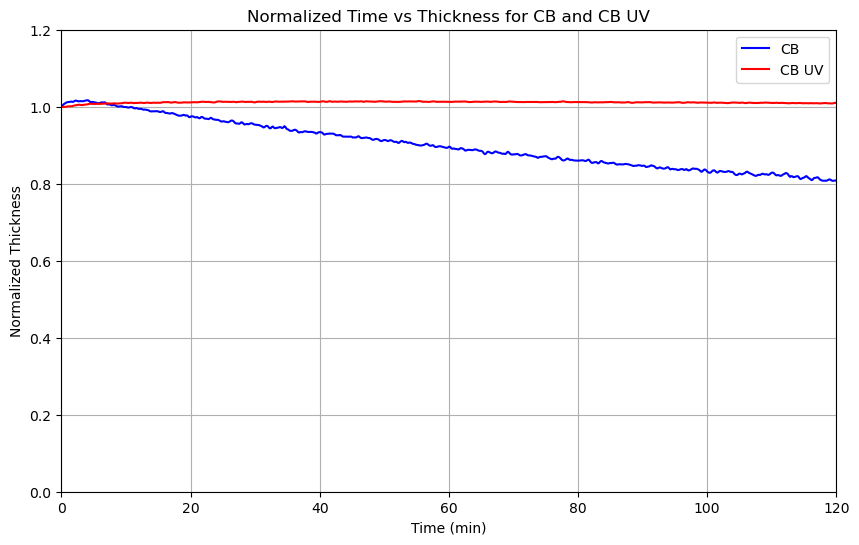

Plot saved as D:\Users\themi\DataspellProjects\MetalconeStability\src\notebooks\figures\plot_DHB_and_DHB UV.png


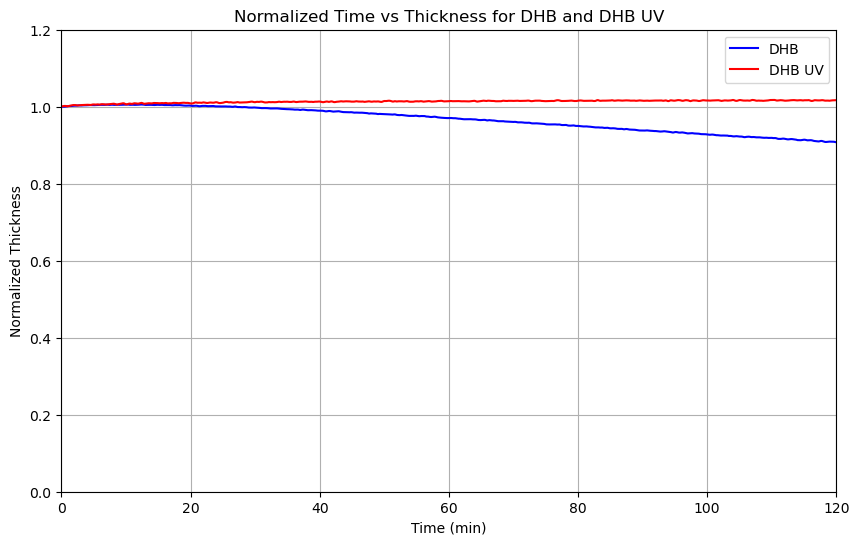

Plot saved as D:\Users\themi\DataspellProjects\MetalconeStability\src\notebooks\figures\plot_MPD_and_MPD UV.png


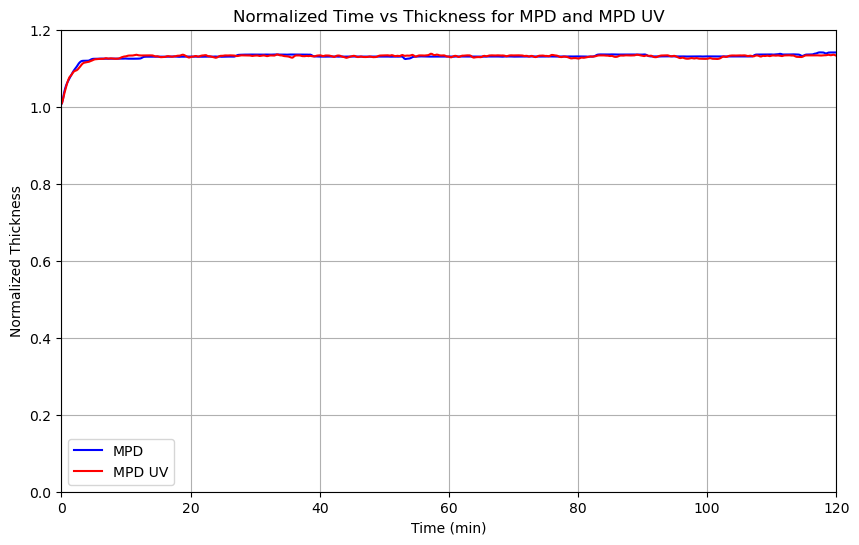

Plot saved as D:\Users\themi\DataspellProjects\MetalconeStability\src\notebooks\figures\plot_EG_and_EG UV.png


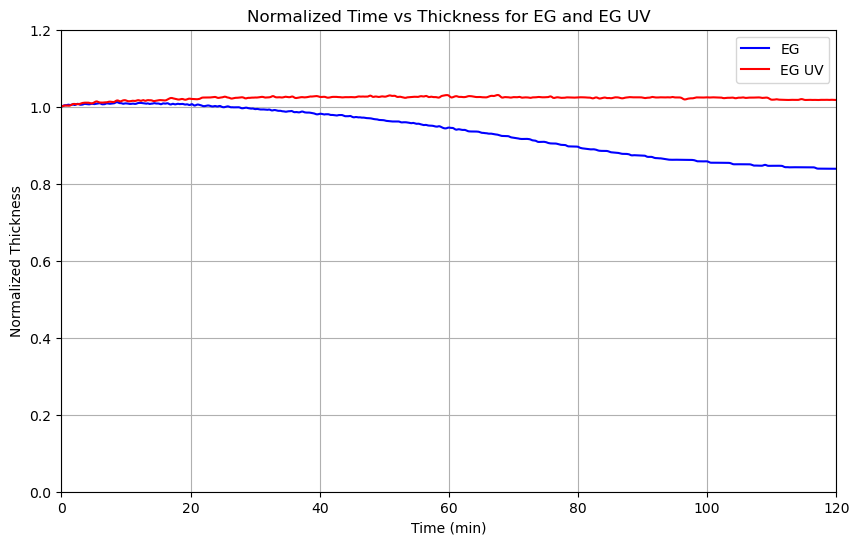

Plot saved as D:\Users\themi\DataspellProjects\MetalconeStability\src\notebooks\figures\plot_THB.png


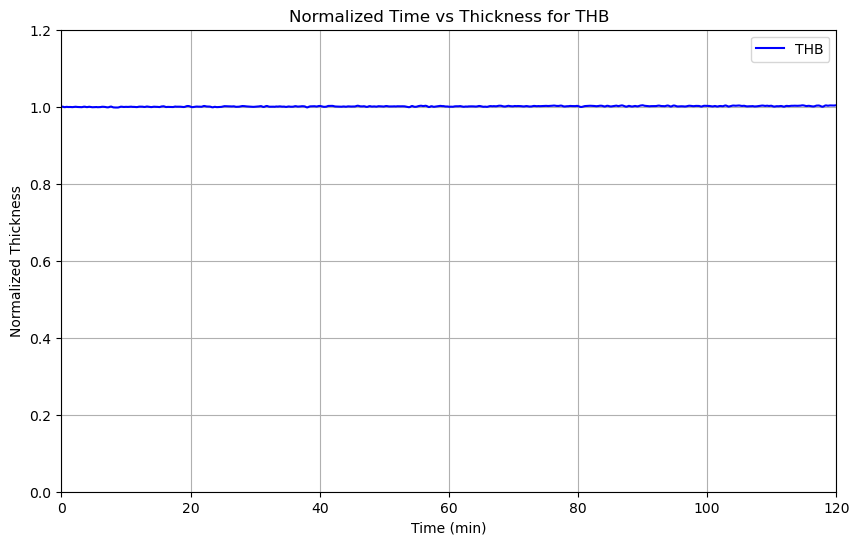

In [85]:
# Call the function to plot all pairs
plot_all_and_save(df, group_pairs, groups)


In [71]:
import pandas as pd
import dataframe_image as dfi


In [88]:
def create_table_image(df, output_filename):
    """Generate a styled table image without row indices and save it for presentation."""
    
    # Round numerical columns to one decimal place
    df_formatted = df.round(1)
    
    # Reset the index to remove row numbers (if needed)
    df_formatted = df_formatted.reset_index(drop=True)
    
    # Apply styling
    styled_df = df_formatted.style.set_caption("Thickness Summary").set_table_styles([
        # Table styles
        {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16pt'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('background-color', '#f2f2f2')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'table', 'props': [('margin', '0 auto'), ('border', '1px solid black')]},
        # Hide the index
        {'selector': '.row_heading', 'props': [('display', 'none')]},
        {'selector': '.index_name', 'props': [('display', 'none')]},
        {'selector': '.blank', 'props': [('display', 'none')]},
    ]).format({
        'Initial Thickness': '{:.1f}',
        'Final Thickness': '{:.1f}',
        'Final Thickness (%)': '{:.1f}%'
    })
    
    # Highlight the Final Thickness (%) column based on value
    styled_df = styled_df.bar(subset=['Final Thickness (%)'], color='#d65f5f', vmax=100)
    
    # Save the styled DataFrame as an image
    dfi.export(styled_df, output_filename)
    print(f"Table saved as {output_filename}")


In [76]:
def create_table_image(df, output_filename):
    """Generate a styled table image without row indices and save it for presentation."""
    
    # Format numbers to one decimal place
    df_formatted = df.round(1)
    
    # Reset the index to remove row numbers
    df_formatted = df_formatted.reset_index(drop=True)
    
    # Apply styling
    styled_df = df_formatted.style.hide_index().set_caption("Thickness Summary").set_table_styles([
        {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16pt'), ('font-weight', 'bold')]},
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('background-color', '#f2f2f2')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'table', 'props': [('margin', '0 auto'), ('border', '1px solid black')]},
    ]).format({'Final Thickness (%)': '{:.1f}%'})
    
    # Highlight the Final Thickness (%) column based on value
    styled_df = styled_df.bar(subset=['Final Thickness (%)'], color='#d65f5f', vmax=100)
    
    # Save the styled DataFrame as an image
    dfi.export(styled_df, output_filename)
